<a href="https://colab.research.google.com/github/rawat-nitin/ColabGoogleStuff/blob/main/Joining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.python.util import tf_decorator
#This command intended to aid in the managment and monitoring of NVIDIA GPU devices
!nvidia-smi

#Libraries required for Downloading and processing the Data-set
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *

#For Early Stopping and Reducing the rate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#For model evaluation
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from numpy import mean
from numpy import std

#Library for required for plotting the Image
from matplotlib import pyplot as plt

Wed Dec 29 11:25:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Function for loading the dataset {plain}
def load_dataset():
  #load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
  #Summarize loaded dataset
  print('Summarizing the Loaded Dataset')
  print('Train: X=%s, y=%s' %(trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' %(testX.shape, testY.shape))
  return trainX, trainY, testX, testY

In [ ]:
def plot_before(trainX, trainY):
  num_row = 2
  num_col = 8
  num =num_row*num_col
  print('Images Before the Augmentation:\n')
  #Plotting the Images
  fig1, axes1 = plt.subplots(num_row,num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
    ax = axes1[i//num_col, i%num_col]
    ax.imshow(trainX[i], cmap='gray_r')
    ax.set_title('Label:{}'.format(trainY[i]))
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_after(trainX, trainY, testX, testY):
  #Reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  trainY = trainY.reshape((trainY.shape[0], 1))
	#Defining the Matplotlib properties
  num_row = 2
  num_col = 8
  num =num_row*num_col
  #Part for the Image Augmentation
  #Creating the class object
  train_image_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.25,
      height_shift_range=0.25,
      shear_range=45,
      zoom_range=0.1,
      horizontal_flip=False,
      fill_mode="nearest"
  )
  #Fitting the Generator
  train_image_datagen.fit(trainX)
  #Plotting the Images
  print('Images After the Augmentation:\n')
  fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num,2*num_row))
  for X, Y in train_image_datagen.flow(trainX, trainY, batch_size=num, shuffle=False):
    for i in range(0, num):
      ax = axes2[i//num_col, i%num_col]
      ax.imshow(X[i].reshape(28,28), cmap='gray_r')
      ax.set_title('Label: {}'.format(int(Y[i])))
    break
  plt.tight_layout()
  plt.show()

In [ ]:
def run_all_features(trainX, trainY, testX, testY):
  #Reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28,1))
  #one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  
  print('Summarzing the Loaded Dataset with Hot coding added')
  print('Train: X=%s, y=%s' %(trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' %(testX.shape, testY.shape))
  return trainX, trainY, testX, testY

In [ ]:
#Scaling pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)


In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='selu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=35, batch_size=32, validation_data=(testX, testY), callbacks=[reduce_lr, early_stopping], verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [ ]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

In [ ]:
def run_main():
  #load dataset
  trainX, trainY, testX, testY = load_dataset()
  plot_before(trainX, trainY)
  plot_after(trainX, trainY, testX, testY)
  trainX, trainY, testX, testY  = run_all_features(trainX, trainY, testX, testY)
  trainX, testX = prep_pixels(trainX, testX)
  #Evaluate Model
  scores, histories = evaluate_model(trainX, trainY)

11501568/11490434 [==============================] - 0s 0us/step
Summarizing the Loaded Dataset
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Images Before the Augmentation:



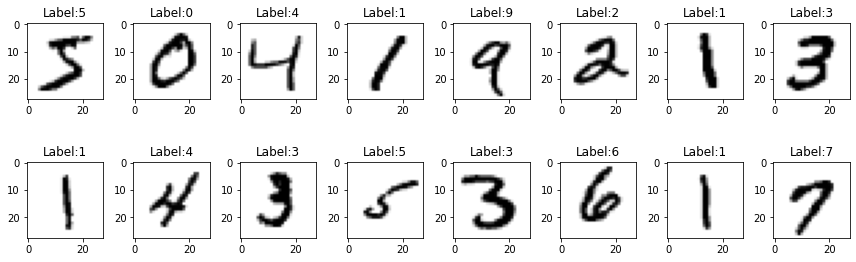

Images After the Augmentation:



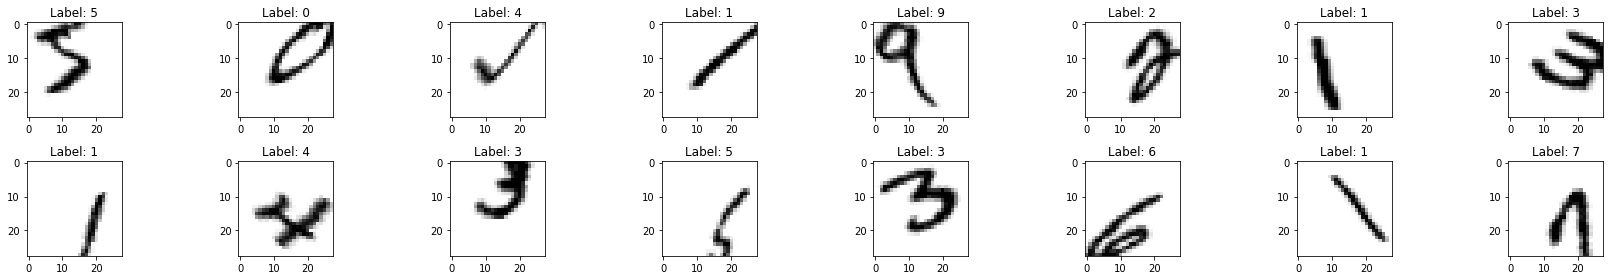

Summarzing the Loaded Dataset with Hot coding added
Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 00017: early stopping
> 99.058

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.


In [ ]:
run_main()